In [18]:
# info about VM.
import sys
print(sys.executable)

/media/HHD_2TB/baurai/aditya_vm/bin/python3.6


In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from tqdm.notebook import tqdm

print(f"Python version = {sys.version}")
print(f"Numpy version = {np.__version__}")
print(f"OpenCV version = {cv2.__version__}")

Python version = 3.6.9 (default, Oct  9 2020, 08:58:16) 
[GCC 6.3.0 20170516]
Numpy version = 1.19.5
OpenCV version = 4.5.1


# Dataset : 

NIH Dataset images available at : "/media/HHD2/NIH/tflow_obj_detection/images"

Metadata for NIH is available at : "/media/HHD2/NIH/tflow_obj_detection/data/Data_Entry_2017_v2020.csv"

In [21]:
DATASET_PATH = "/media/HHD2/NIH/tflow_obj_detection/images/"
METADATA_PATH = "/media/HHD2/NIH/tflow_obj_detection/data/Data_Entry_2017_v2020.csv"

In [22]:
df = pd.DataFrame(pd.read_csv(METADATA_PATH))

print(f"Shape of the dataframe = {df.shape}")
print(f"Number of images found = {len(os.listdir(DATASET_PATH))}")

Shape of the dataframe = (112120, 11)
Number of images found = 112120


In [23]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


Check for missing entries.

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
dtypes: float64(2), int64(5), object(4)
memory usage: 9.4+ MB


So, we don't have any missing entry in the metadata file. 

# Basic Functions For Image Loading & Resizing.

Also the images are essentially grayscale(*actually grayscale stacked behind one another to form a 3-D tensor*). Hence, we skip the BGR2RGB argument during image reading, via OpenCV.

In [25]:
def load_image(base_path, image_name) : 
    image_path = os.path.join(base_path, image_name)
    image = cv2.imread(image_path)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [26]:
def resize_image(image, image_size) : 
    image = cv2.resize(image, (image_size[0], image_size[1]), interpolation = cv2.INTER_AREA)
    return image

## Load Some Images : 

In [27]:
random_image_names = [np.random.choice(os.listdir(DATASET_PATH)) for i in range(4)]

random_image_names

['00025937_004.png',
 '00002453_000.png',
 '00012070_001.png',
 '00022815_015.png']

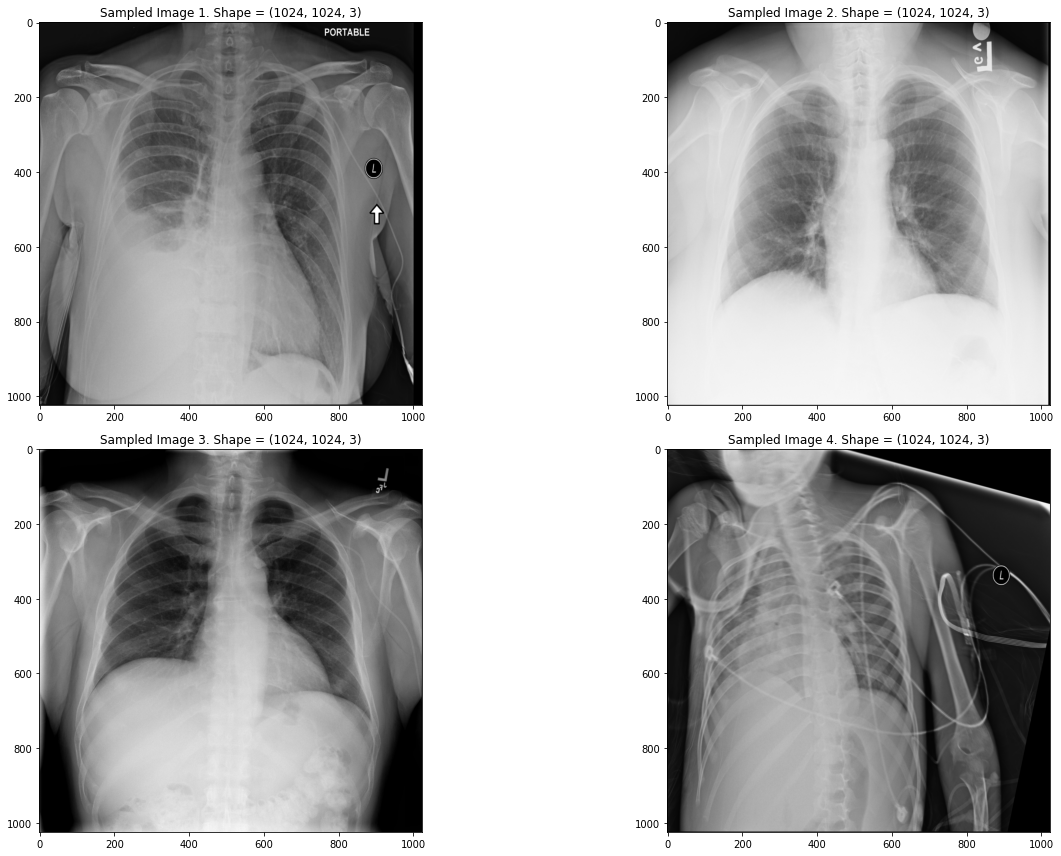

In [29]:
plt.figure(figsize = (20, 12))
for i in range(4) : 
    plt.subplot(2, 2, i+1)
    image = load_image(DATASET_PATH, random_image_names[i])
    plt.title(f"Sampled Image {i + 1}. Shape = {image.shape}")
    plt.imshow(image)
    plt.grid(False)

plt.tight_layout()

# Need For EDA : 

When we’re getting started with a machine learning (ML) project, one critical principle to keep in mind is that data is everything. It is often said that if ML is the rocket engine, then the fuel is the (high-quality) data fed to ML algorithms. However, deriving truth and insight from a pile of data can be a complicated and error-prone job. To have a solid start for our ML project, it always helps to analyze the data up front.

During EDA, it’s important that we get a deep understanding of:

* The properties of the data, such as schema and statistical properties;
* The quality of the data, like missing values and inconsistent data types;
* The predictive power of the data, such as correlation of features against target.

## Label Count : 

In [32]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168
